# Imports

In [ ]:
import pandas as pd
import math
import numpy as np
import random
from matplotlib import pyplot as plt
from scipy.spatial.distance import euclidean
from sklearn import cluster
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

In [ ]:
tracks = pd.read_csv('tracks.csv')
artists = pd.read_csv('artists.csv')
tracks.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.9180,0.104,0.397,169.980,3
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.1300,0.311,0.196,103.220,4


In [ ]:
tracks.shape

(586672, 20)

In [ ]:
artists.head()

,id,followers,genres,name,popularity
0,0DheY5irMjBUeLybbCUEZ2,0.0,[],Armid & Amir Zare Pashai feat. Sara Rouzbehani,0
1,0DlhY15l3wsrnlfGio2bjU,5.0,[],ปูนา ภาวิณี,0
2,0DmRESX2JknGPQyO15yxg7,0.0,[],Sadaa,0
3,0DmhnbHjm1qw6NCYPeZNgJ,0.0,[],Tra'gruda,0
4,0Dn11fWM7vHQ3rinvWEl4E,2.0,[],Ioannis Panoutsopoulos,0


# Pre-processing

In [ ]:
# Deal with missing data
missing_cols = tracks.isnull().sum().sort_values(ascending=False)
missing_cols.head()

name        71
id           0
tempo        0
valence      0
liveness     0
dtype: int64

In [ ]:
# Remove tracks that don't have a name
missing_names = tracks.isnull().sum(axis=1)
missing_index = list( missing_names[ missing_names > 0 ].index )
print( tracks.iloc[ missing_index ] )
tracks.drop( missing_index, inplace=True )

Empty DataFrame
Columns: [id, name, popularity, duration_ms, explicit, artists, id_artists, release_date, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, time_signature]
Index: []


In [ ]:
# Drop ancient tracks to focus more on more recent track data
tracks = tracks[ tracks['release_date'] > 2016 ]
tracks.shape

In [ ]:
# Drop qualitative features as K-means asks for quantitative data
cols_to_drop = []
for column in tracks:
    if tracks[column].dtype == 'object':
        cols_to_drop.append(column)
quantitative_X = tracks.drop( columns=cols_to_drop )
quantitative_X.head()

In [ ]:
# Drop columns that are not related to the characteristic of songs, because
# we want to focus on the traits of those songs
# mode is a categorical feature with only 2 values, drop it as well as it is
# not very useful given that we have multiple clusters
cols_to_drop = ["duration_ms", "mode"]
quantitative_X = quantitative_X.drop( columns=cols_to_drop )
quantitative_X.head()

In [ ]:
# Normalize data
for column in quantitative_X.columns:
  print(column)
  quantitative_X[ column ] = quantitative_X[ column ].apply( lambda row : row - quantitative_X[column].min()) / (quantitative_X[column].max() - quantitative_X[column].min())
quantitative_X.head()

In [ ]:
processed = quantitative_X.copy(deep=True)

# K-Means

## Elbow method

In [ ]:
# Split dataset to training and validation
# train = processed.sample(frac=0.8,random_state=100)
dev = processed.sample(frac=0.2,random_state=100)
dev.shape

In [ ]:
def elbow_method(dev_X, is_kmeans=True, max_range=30):
  model_objs = [ np.inf, np.inf ]
  s_scores = [ np.inf, np.inf ]
  for k in range(2, max_range):
    if is_kmeans:  # k-means clustering
      model = cluster.KMeans(n_clusters=k)
      model.fit(dev_X)
      model_obj = -model.score(dev_X)
      s_score = metrics.silhouette_score(dev_X, model.labels_)
    else:  # GMM
      model = GaussianMixture(n_components=k, random_state=0)
      labels = model.fit_predict(dev_X)
      model_obj = model.score(dev_X)
      s_score = metrics.silhouette_score(dev_X, labels)
    print(f"when k={k}, model_objectives={model_obj}, s_score={s_score}")
    model_objs.append(model_obj)
    s_scores.append(s_score)
  return model_objs, s_scores

In [ ]:
j_scores, s_scores = elbow_method(dev.to_numpy(), is_kmeans=True)

In [ ]:
def graph_elbow_method(scores, num_clusters, y_label_str="Score", title="Elbow Method with score"):
  Ks = range(len(scores))
  plt.plot(Ks, scores, '.-', markersize=15)
  plt.xlabel('k')
  plt.scatter([num_clusters], [scores[num_clusters]], s=200, c='r')
  plt.xlabel("Number of clusters K")
  plt.ylabel(y_label_str)
  plt.title(title)

In [ ]:
kmeans_num_clusters = 7

In [ ]:
# graph for j scores
graph_elbow_method(j_scores, kmeans_num_clusters, y_label_str="Objective Function Value", title="Elbow Method with j_score")

In [ ]:
# graph for Silhouette Coefficient
graph_elbow_method(s_scores, kmeans_num_clusters, y_label_str="Silhouette Coefficient", title="Inspect Silhouette Coefficient")

## Train model

In [ ]:
# Fit a K-Means to detect clusters
# To avoid overfitting, we will choose the k that is at the 'elbow' (where the rate of J-score decrease substantially slows down)
train_X = processed.to_numpy()
kmeans = cluster.KMeans(n_clusters=kmeans_num_clusters)
kmeans.fit(train_X)

In [ ]:
print('K-Means Objective: %.2f' % -kmeans.score(train_X))
print('Silhouette Coefficient: %.2f' % metrics.silhouette_score(train_X, kmeans.labels_))
print('Calinski-Harabasz Index: %.2f' % metrics.calinski_harabasz_score(train_X, kmeans.labels_))

In [ ]:
kmeans.labels_

## Visualize Clusters

In [ ]:
visualize_df = processed.copy(deep=True)
visualize_df['cluster'] = kmeans.labels_
visualize_df

In [ ]:
kmeans_df_radar = visualize_df.groupby('cluster').mean().reset_index()
kmeans_df_radar

In [ ]:
# https://python-graph-gallery.com/392-use-faceting-for-radar-chart/
def make_spider(row, title, color, df_radar, num_clusters):
    # number of variable
    categories = list(df_radar)[1:]
    N = len(categories)
    
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * math.pi for n in range(N)]
    angles += angles[:1]
    
    # Initialise the radar plot
    ax = plt.subplot(2, math.ceil(num_clusters / 2),row+1, polar=True)
    
    # If you want the first axis to be on top:
    ax.set_theta_offset(math.pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=14)    

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.2,0.4,0.6,0.8], ["0.2","0.4","0.6","0.8"], color="grey", size=8)
    plt.ylim(0,1)

    # Ind1
    values = df_radar.loc[row].drop('cluster').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=30, color=color, y=1.1)


In [ ]:
# initialize the figure
plt.figure(figsize=(40, 20))
 
# Create a color palette:
my_palette = plt.cm.get_cmap("brg", len(kmeans_df_radar.index))
 
# Loop to plot
for row in range(0, len(kmeans_df_radar.index)):
    make_spider(row, f"Cluster {row}", my_palette(row), kmeans_df_radar, kmeans_num_clusters)

## Application: Recommend songs using K-Means

In [ ]:
# play with this model, pick multiple songs in 2019-2020
exp_track_name = ["Save Your Tears", "Memories", "Don't Start Now", "Circles", "Blinding Lights", "Rockstar"]
exp_playlist_length = 10

In [ ]:
def generate_playlist(input_track_names, playlist_length, num_clusters, labels):
  input_track_index = []
  for i in input_track_names:
    input_track_index.append(tracks.index[tracks["name"] == i][0])

  clustered_tracks = tracks.copy(deep=True)
  clustered_tracks['cluster'] = labels

  # Analysing the percentage of songs per cluster
  input_track_index_clusters = []
  for i in input_track_index:
    input_track_train_loc = processed.index.get_loc(i)
    input_track_index_clusters.append(labels[input_track_train_loc])

  num_song_per_cluster = {}
  for i in range(num_clusters):
    num_song_per_cluster[i] = input_track_index_clusters.count(i) / len(input_track_index_clusters) * playlist_length
  num_song_per_cluster

  # Generate playlist
  playlist = pd.DataFrame()
  for ncluster, pct in num_song_per_cluster.items():
      cur_tracks = clustered_tracks[clustered_tracks['cluster'] == ncluster].sample(n=int(round(pct, 0)))
      playlist = pd.concat([playlist, cur_tracks], ignore_index=True)

  playlist = playlist.sample(n=playlist_length).reset_index().drop(columns=['index'])
  
  return playlist

In [ ]:
recommended_playlist = generate_playlist(exp_track_name, exp_playlist_length, kmeans_num_clusters, kmeans.labels_) 
recommended_playlist

# GMM

## Elbow method

In [ ]:
log_likelihood, s_scores = elbow_method(dev.to_numpy(), is_kmeans=False)

In [ ]:
gmm_num_clusters = 9

In [ ]:
# graph for log-likelihood
graph_elbow_method(log_likelihood, gmm_num_clusters, y_label_str="Objective Function Value", title="Elbow Method with GMM log-likelihood")

In [ ]:
# graph for Silhouette Coefficient
graph_elbow_method(s_scores, gmm_num_clusters, y_label_str="Silhouette Coefficient", title="Inspect Silhouette Coefficient")

## Train model

In [ ]:
# GMM
train_X = processed.to_numpy()
gmm = GaussianMixture(n_components=gmm_num_clusters)
gmm_labels = gmm.fit_predict(train_X)
display(len(train_X), len(gmm_labels))
display(gmm_labels)

In [ ]:
print('GMM objective: %.2f' % gmm.score(train_X))
print('Silhouette Coefficient: %.2f' % metrics.silhouette_score(train_X, gmm_labels))
print('Calinski-Harabasz Index: %.2f' % metrics.calinski_harabasz_score(train_X, gmm_labels))

the Silhouette Coefficient from GMM is actually worse than k-means


## Visualize clusters

In [ ]:
gmm_visualize_df = processed.copy(deep=True)
gmm_visualize_df['cluster'] = gmm_labels
gmm_visualize_df

In [ ]:
gmm_df_radar = gmm_visualize_df.groupby('cluster').mean().reset_index()
gmm_df_radar

In [ ]:
# initialize the figure
plt.figure(figsize=(40, 20))
 
# Create a color palette:
my_palette = plt.cm.get_cmap("brg", len(gmm_df_radar.index))
 
# Loop to plot
for row in range(0, len(gmm_df_radar.index)):
    make_spider(row, f"Cluster {row}", my_palette(row), gmm_df_radar, gmm_num_clusters)

## Application: Recommend songs using GMM

In [ ]:
recommended_playlist = generate_playlist(exp_track_name, exp_playlist_length, gmm_num_clusters, gmm_labels) 
recommended_playlist

# PCA

## Hyperparameter tuning

n=2
n=3
n=4
n=5
n=6
n=7
n=8
n=9
n=10
n=11
n=12
n=13


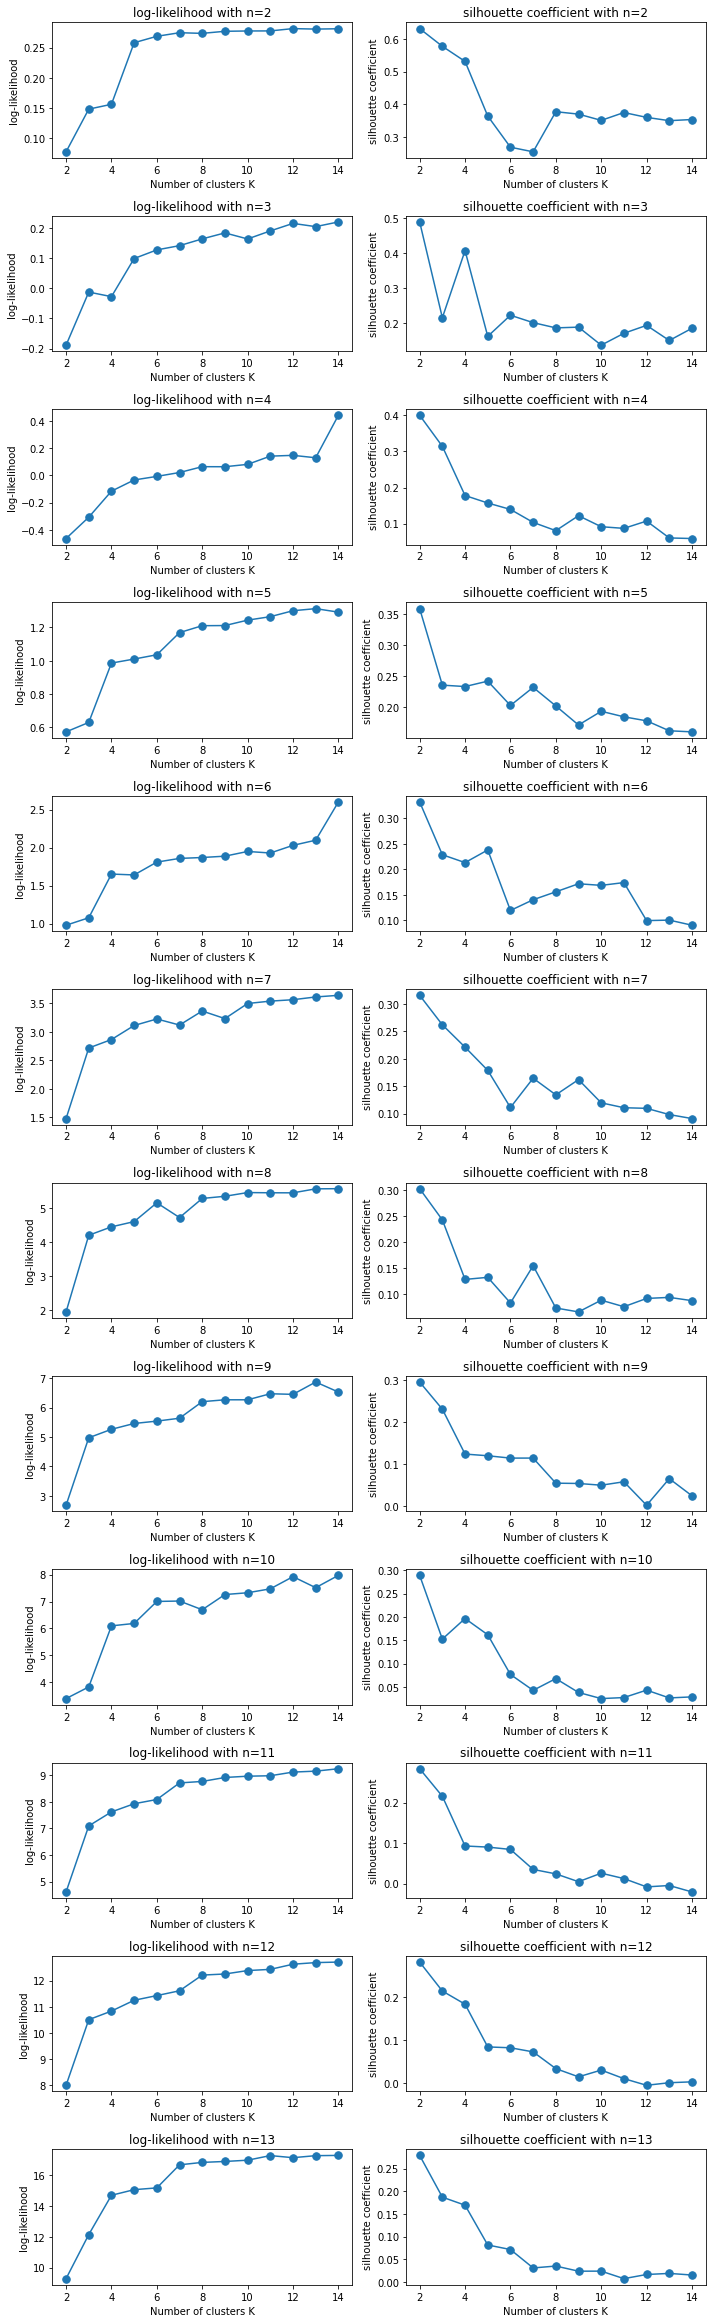

In [ ]:
# for GMM
fig = plt.figure(figsize=(10, 40))
dev_X = dev.to_numpy()
i = 0
for n in range(2, len(processed.columns)):
  pca = PCA(n_components=n)
  pca.fit(dev_X)
  X_pca_array = pca.transform(dev_X)
  pca_processed = pd.DataFrame(X_pca_array)

  gmm_scores, s_scores = [np.inf, np.inf], [np.inf, np.inf]
  for k in range(2, 15):
    gmm = GaussianMixture(n_components=k)
    labels = gmm.fit_predict(pca_processed)
    gmm_score = gmm.score(pca_processed)
    s_score = metrics.silhouette_score(pca_processed, labels)
    gmm_scores.append(gmm_score)
    s_scores.append(s_score)
  print(f"n={n}")

  ax = fig.add_subplot(15, 2, i+1)
  Ks = range(len(gmm_scores))
  plt.plot(Ks, gmm_scores, '.-', markersize=15)
  ax.set_title(f"log-likelihood with n={n}")
  ax.set_xlabel("Number of clusters K")
  ax.set_ylabel("log-likelihood")
  i += 1

  ax = fig.add_subplot(15, 2, i+1)
  Ks = range(len(s_scores))
  plt.plot(Ks, s_scores, '.-', markersize=15)
  ax.set_title(f"silhouette coefficient with n={n}")
  ax.set_xlabel("Number of clusters K")
  ax.set_ylabel("silhouette coefficient")
  i += 1

fig.tight_layout()  # Improves appearance a bit.
plt.show()

n=2
n=3
n=4
n=5
n=6
n=7
n=8
n=9
n=10
n=11
n=12
n=13


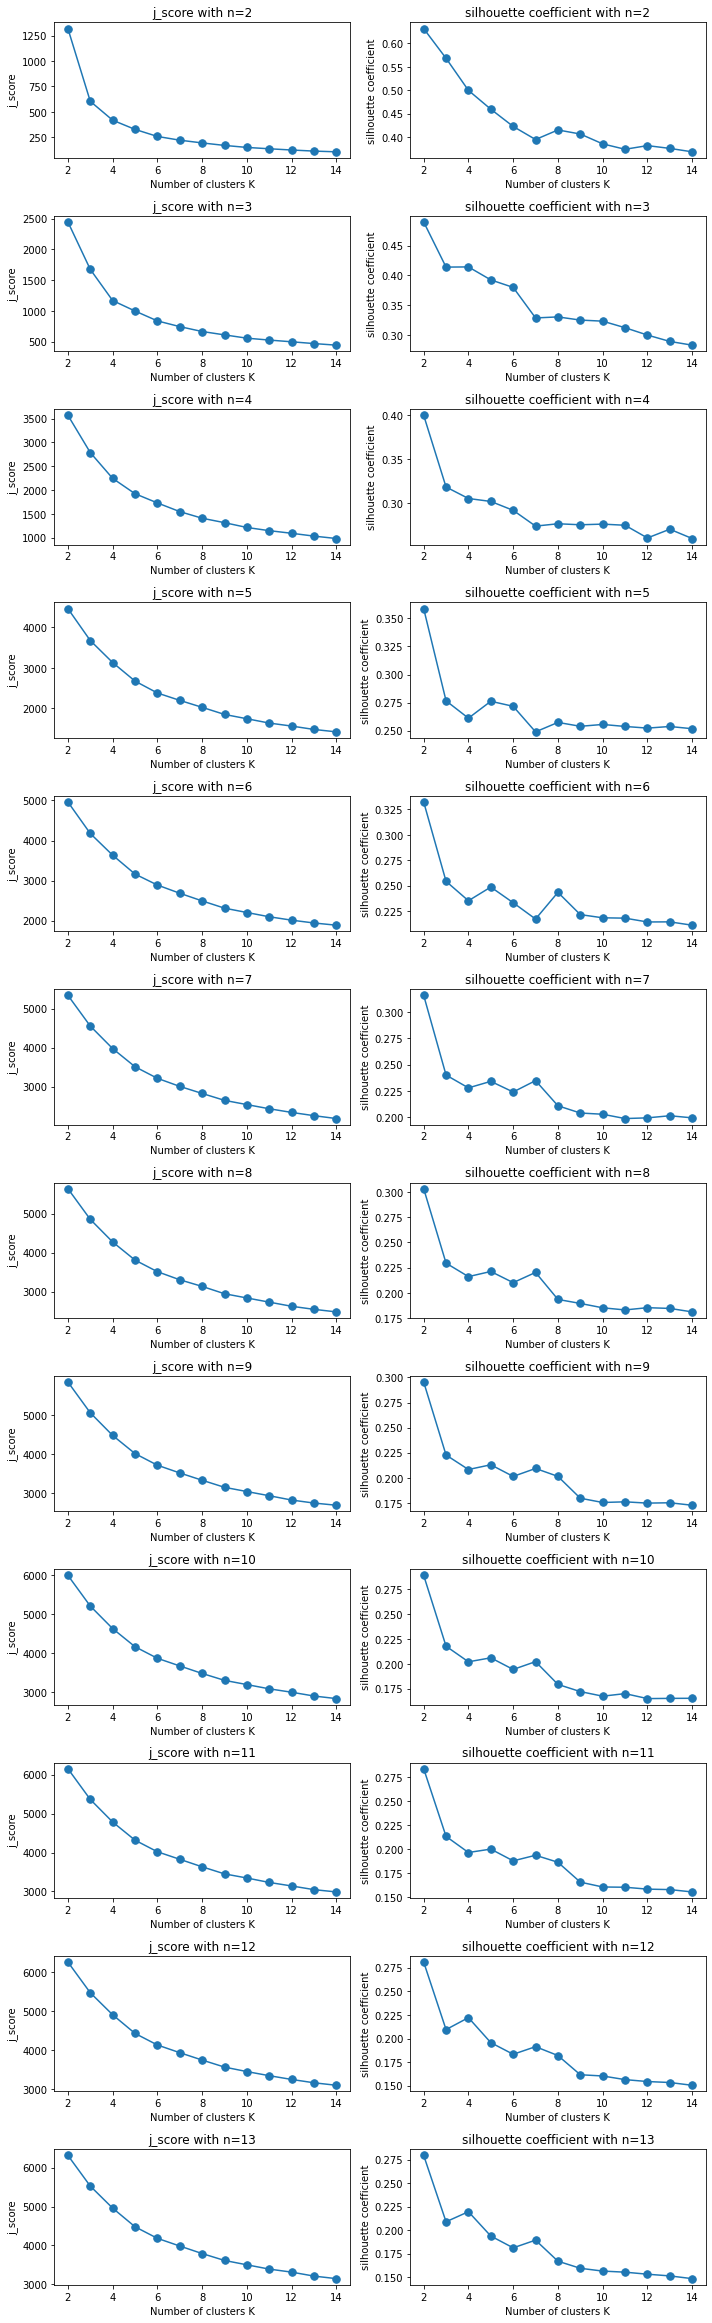

In [ ]:
# for k means
fig = plt.figure(figsize=(10, 40))
dev_X = dev.to_numpy()
i = 0
for n in range(2, len(processed.columns)):
  pca = PCA(n_components=n)
  pca.fit(dev_X)
  X_pca_array = pca.transform(dev_X)
  pca_processed = pd.DataFrame(X_pca_array)

  kmeans_scores, s_scores = [np.inf, np.inf], [np.inf, np.inf]
  for k in range(2, 15):
    kmeans = cluster.KMeans(n_clusters=k)
    kmeans.fit(pca_processed)
    kmeans_score = -kmeans.score(pca_processed)
    s_score = metrics.silhouette_score(pca_processed, kmeans.labels_)
    kmeans_scores.append(kmeans_score)
    s_scores.append(s_score)
  print(f"n={n}")

  ax = fig.add_subplot(15, 2, i+1)
  Ks = range(len(kmeans_scores))
  plt.plot(Ks, kmeans_scores, '.-', markersize=15)
  ax.set_title(f"j_score with n={n}")
  ax.set_xlabel("Number of clusters K")
  ax.set_ylabel("j_score")
  i += 1

  ax = fig.add_subplot(15, 2, i+1)
  Ks = range(len(s_scores))
  plt.plot(Ks, s_scores, '.-', markersize=15)
  ax.set_title(f"silhouette coefficient with n={n}")
  ax.set_xlabel("Number of clusters K")
  ax.set_ylabel("silhouette coefficient")
  i += 1

fig.tight_layout()  # Improves appearance a bit.
plt.show()

## PCA + GMM

In [ ]:
ndimensions = 2
pca_gmm_num_clusters = 7

In [ ]:
pca = PCA(n_components=ndimensions)
pca.fit(train_X)
X_pca_array = pca.transform(train_X)
pca_processed = pd.DataFrame(X_pca_array)

In [ ]:
# GMM
gmm = GaussianMixture(n_components=pca_gmm_num_clusters)
labels = gmm.fit_predict(pca_processed)

In [ ]:
print('GMM objective: %.2f' % gmm.score(pca_processed))
print('Silhouette Coefficient: %.2f' % metrics.silhouette_score(pca_processed, labels))

GMM objective: 0.27
Silhouette Coefficient: 0.34


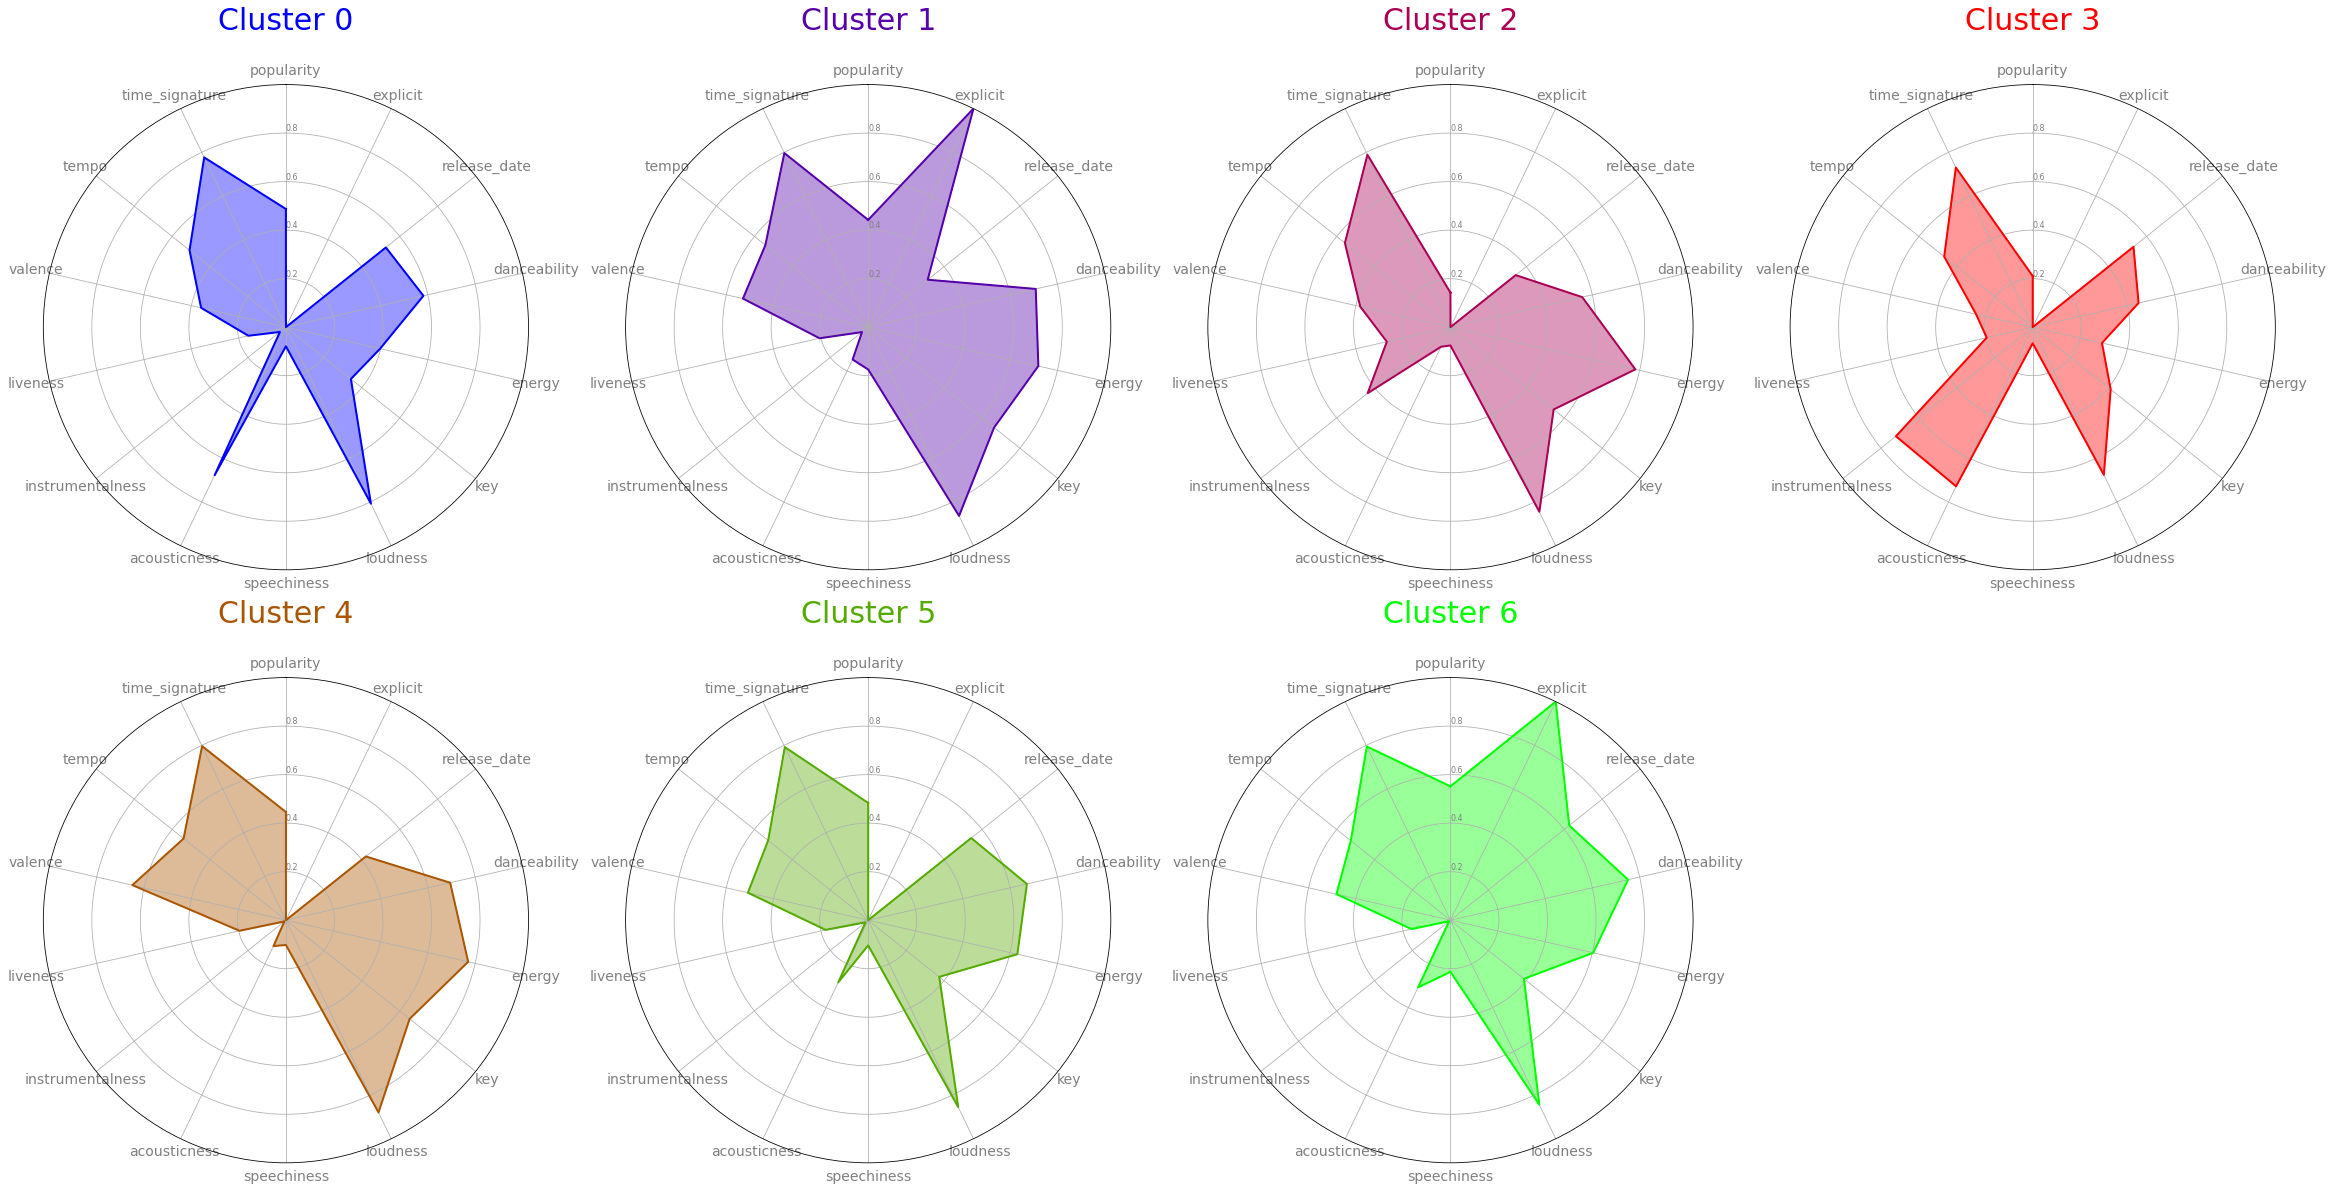

In [ ]:
gmm_visualize_df = processed.copy(deep=True)
gmm_visualize_df['cluster'] = labels
gmm_df_radar = gmm_visualize_df.groupby('cluster').mean().reset_index()

# initialize the figure
plt.figure(figsize=(40, 20))
 
# Create a color palette:
my_palette = plt.cm.get_cmap("brg", len(gmm_df_radar.index))
 
# Loop to plot
for row in range(0, len(gmm_df_radar.index)):
    make_spider(row, f"Cluster {row}", my_palette(row), gmm_df_radar, pca_gmm_num_clusters)

## PCA + KMeans

In [ ]:
ndimensions = 2
pca_kmeans_num_clusters = 7

pca = PCA(n_components=ndimensions)
pca.fit(train_X)
X_pca_array = pca.transform(train_X)
pca_processed = pd.DataFrame(X_pca_array)

kmeans = cluster.KMeans(n_clusters=pca_kmeans_num_clusters)
kmeans.fit(pca_processed)

print('K-Means Objective: %.2f' % -kmeans.score(pca_processed))
print('Silhouette Coefficient: %.2f' % metrics.silhouette_score(pca_processed, kmeans.labels_))

K-Means Objective: 1122.77
Silhouette Coefficient: 0.40


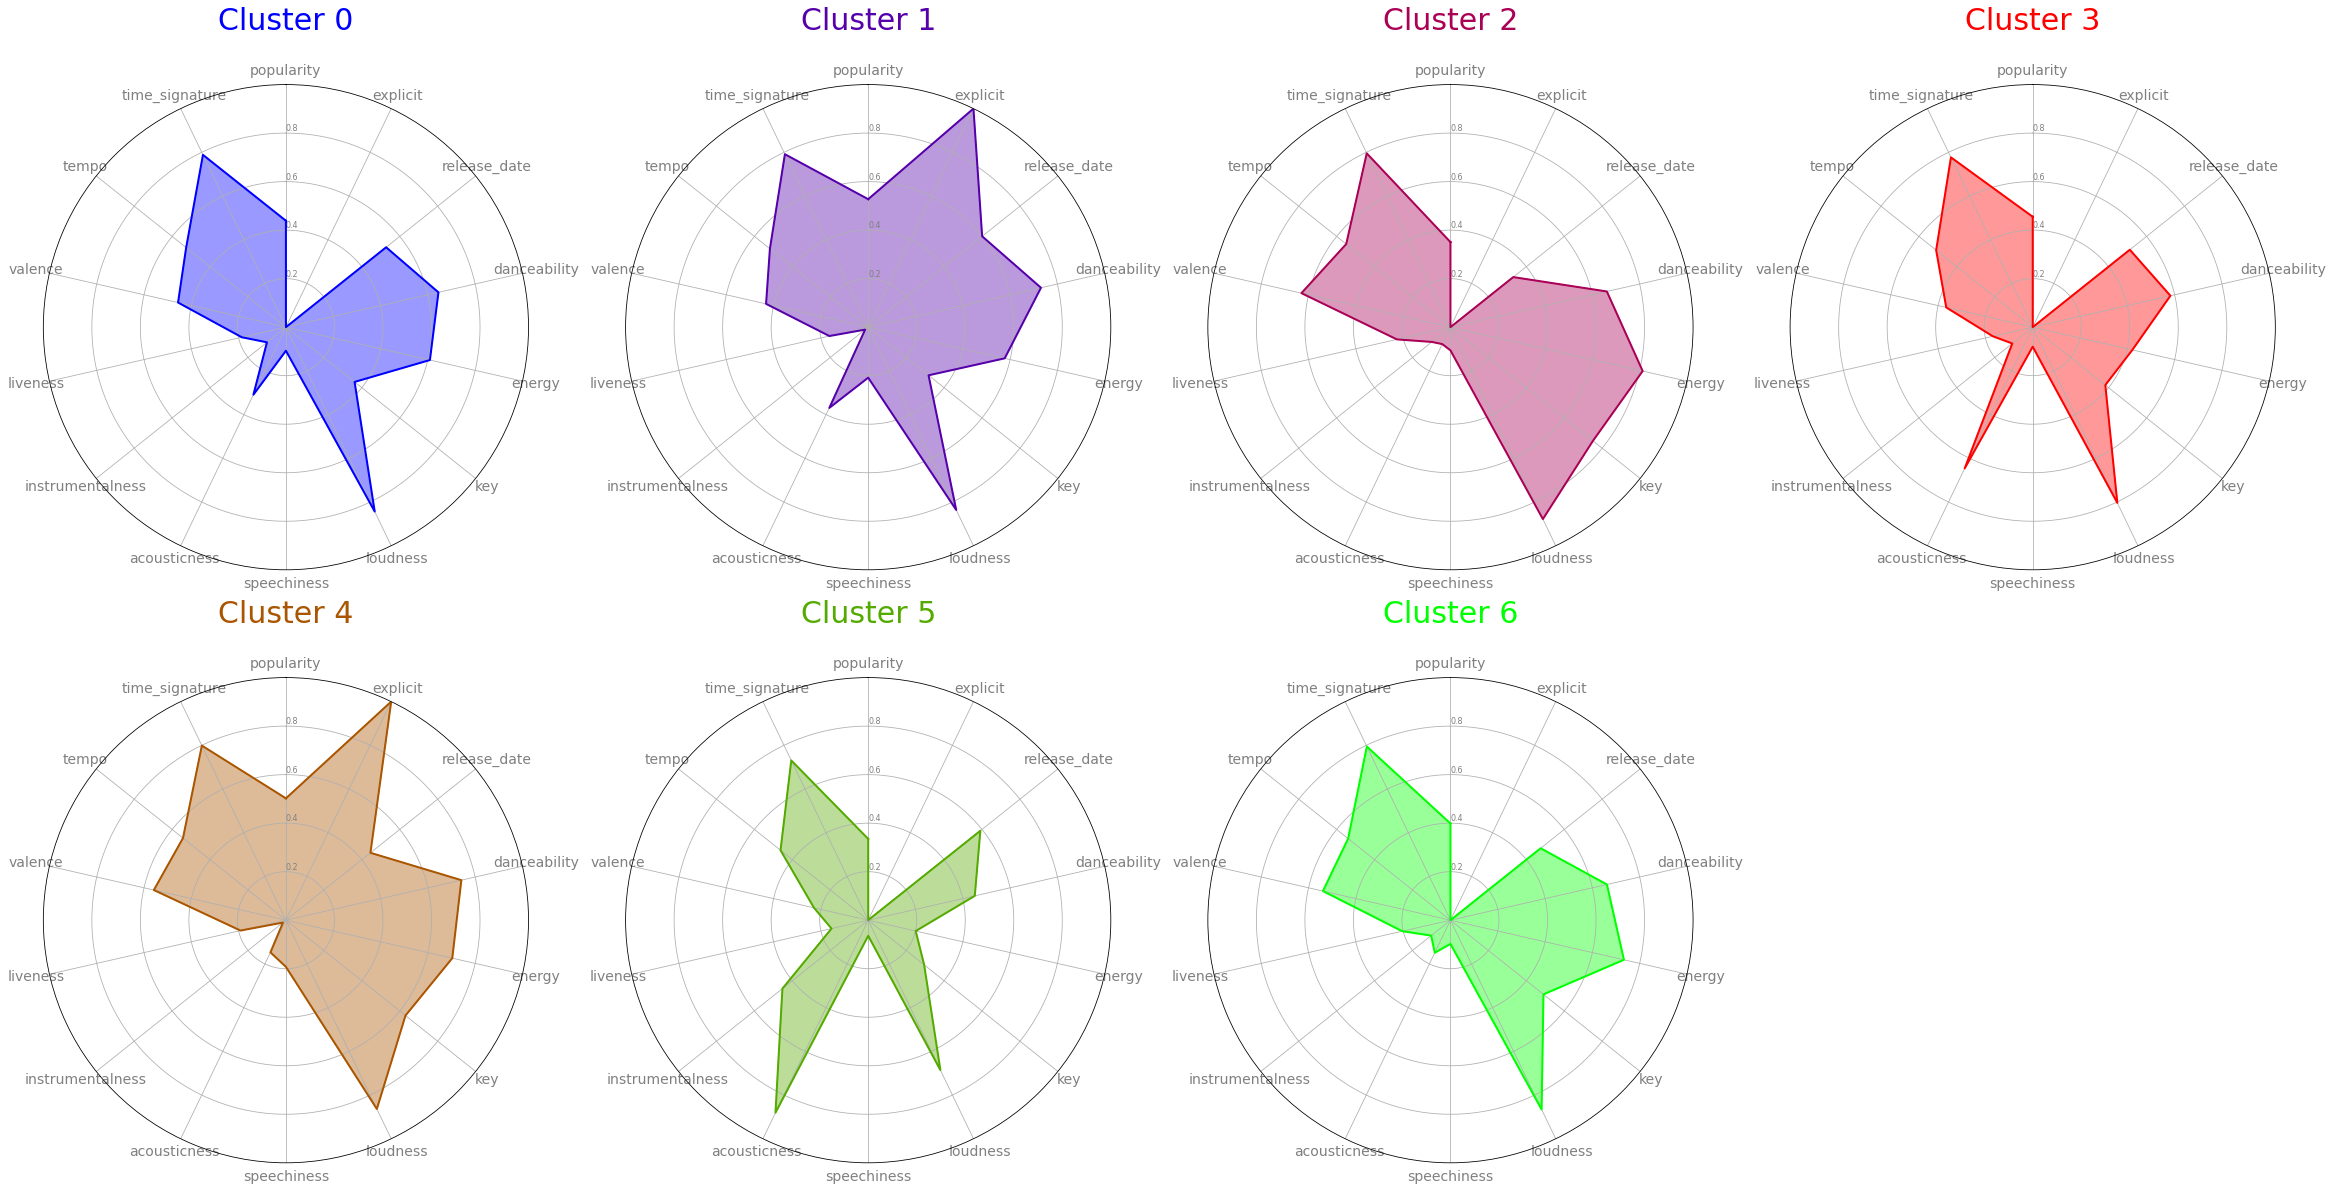

In [ ]:
visualize_df = processed.copy(deep=True)
visualize_df['cluster'] = kmeans.labels_

kmeans_df_radar = visualize_df.groupby('cluster').mean().reset_index()

# initialize the figure
plt.figure(figsize=(40, 20))
 
# Create a color palette:
my_palette = plt.cm.get_cmap("brg", len(kmeans_df_radar.index))
 
# Loop to plot
for row in range(0, len(kmeans_df_radar.index)):
    make_spider(row, f"Cluster {row}", my_palette(row), kmeans_df_radar, pca_kmeans_num_clusters)